In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import seaborn as sns
import os

#os.chdir('C:/Users/tirki/Dropbox/Trabajos/Energía')

import scipy.stats as stats
from scipy.stats import gaussian_kde
from scipy.linalg import cholesky

#from SequeraModels import build_model, test_set_analysis

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

from joblib import Parallel, delayed

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sodapy import Socrata

# Configurar el estilo de seaborn para un aspecto más profesional
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [326]:
# FUNCIONES DE SCRAPPING

from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import os

def obtener_datos_diarios(url, max_intentos=3):
    for intento in range(max_intentos):
        try:
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Buscar el encabezado "Resum diari"
            h2 = soup.find('h2', string='Resum diari')
            if not h2:
                print(f"No se encontró el encabezado 'Resum diari' en la URL: {url}")
                return None
            
            # Buscar la tabla que sigue al encabezado
            table = h2.find_next('table')
            if not table:
                print(f"No se encontró la tabla después del encabezado 'Resum diari' en la URL: {url}")
                return None
            
            datos = {}
            for row in table.find_all('tr'):
                header = row.find('th')
                value = row.find('td')
                if header and value:
                    header_text = header.text.strip()
                    value_text = value.text.strip()
                    if value_text == "sense dades": value_text = "-1"
                    
                    if header_text == "Temperatura mitjana":
                        datos['Temperatura media'] = float(value_text.split()[0])
                    elif header_text == "Temperatura màxima":
                        datos['Temperatura máxima'] = float(value_text.split()[0])
                    elif header_text == "Temperatura mínima":
                        datos['Temperatura mínima'] = float(value_text.split()[0])
                    elif header_text == "Humitat relativa mitjana":
                        datos['Humedad relativa media'] = float(value_text.rstrip('%'))
                    elif header_text == "Precipitació acumulada":
                        datos['Precipitación acumulada'] = float(value_text.split()[0])
                    elif header_text == "Gruix de neu màxim":
                        datos['Grueso máximo de nieve'] = float(value_text.split()[0])
                    elif header_text == "Irradiació solar global":
                        datos['Irradiación solar global'] = float(value_text.split()[0])
            
            if not datos:
                print(f"No se encontraron datos en la tabla para la URL: {url}")
                return None
            
            return datos
        except requests.RequestException as e:
            print(f"Error de solicitud en el intento {intento + 1} para {url}: {e}")
        except Exception as e:
            print(f"Error inesperado en el intento {intento + 1} para {url}: {e}")
        
        if intento < max_intentos - 1:
            time.sleep(2)
    
    print(f"No se pudo obtener datos para {url} después de {max_intentos} intentos")
    return None


def generar_urls(codigo_estacion, fecha_inicio, fecha_fin):
    fecha_actual = fecha_inicio
    while fecha_actual <= fecha_fin:
        yield f"https://www.meteo.cat/observacions/xema/dades?codi={codigo_estacion}&dia={fecha_actual.strftime('%Y-%m-%d')}T00:00Z"
        fecha_actual += timedelta(days=1)

def scrape_estacion(codigo_estacion, fecha_inicio, fecha_fin):
    datos = []
    for url in generar_urls(codigo_estacion, fecha_inicio, fecha_fin):
        fecha = url.split('dia=')[1].split('T')[0]
        datos_diarios = obtener_datos_diarios(url, max_intentos=5)
        if datos_diarios:
            datos_diarios['Fecha'] = fecha
            datos.append(datos_diarios)
            print(f"Datos obtenidos para la estación {codigo_estacion}, fecha: {fecha}")
        else:
            print(f"No se pudo obtener datos para la estación {codigo_estacion}, fecha: {fecha}")
    
    df = pd.DataFrame(datos)
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df.set_index('Fecha', inplace=True)
    return df

def actualizar_csv(codigo_estacion, nuevos_datos, add_to_start = False):
    directorio = 'internes'
    nombre_archivo = f'estacio_{codigo_estacion}.csv'
    ruta_completa = os.path.join(directorio, nombre_archivo)

    if os.path.exists(ruta_completa):
        # Cargar datos existentes
        df_existente = pd.read_csv(ruta_completa, index_col='Fecha', parse_dates=['Fecha'])
        
        # Combinar datos existentes con nuevos datos
        if add_to_start:
            df_combinado = pd.concat([nuevos_datos, df_existente])
        else:
            df_combinado = pd.concat([df_existente, nuevos_datos])
                
        # Eliminar duplicados, manteniendo la última entrada
        df_combinado = df_combinado[~df_combinado.index.duplicated(keep='last')]
        
        # Ordenar por fecha
        df_combinado = df_combinado.sort_index()
    else:
        df_combinado = nuevos_datos

    # Guardar el DataFrame combinado
    df_combinado.to_csv(ruta_completa, encoding='utf-8-sig')
    print(f"Datos actualizados para la estación {codigo_estacion} en {nombre_archivo}")

In [14]:
# Directorio donde se encuentran los archivos CSV
directorio = 'stations'

# Lista para almacenar los dataframes de cada estación
dataframes = []

# Recorrer todos los archivos CSV en el directorio
for filename in os.listdir(directorio):
    if filename.endswith('.csv'):
        # Cargar el CSV
        df = pd.read_csv(os.path.join(directorio, filename), parse_dates=['Fecha'], index_col='Fecha')
              
        # Renombrar la columna de precipitación con el nombre del archivo (sin la extensión)
        estacion = os.path.splitext(filename)[0]
        df = df.rename(columns={'Precipitación acumulada': estacion})
        
        # Seleccionar solo la columna de precipitación
        df = df[[estacion]]
        
        dataframes.append(df)

# Combinar todos los dataframes
df_final = pd.concat(dataframes, axis=1)

In [18]:
# DATA CLEANING
# Fecha de corte de los datos del modelo
# (para que el modelo trabaje correctamente debe ser una fecha de final de mes)
end_dataset_date = '2024-11-30'

precipitations = df_final

# Excluimos las estaciones de la Vall d'Aran
precipitations = precipitations.drop(['estacio_VS','estacio_Z6'], axis=1)

# Truncamos el dataset desde 2008 y hasta la fecha fina
precipitations = precipitations['2008-01-01':end_dataset_date]

# Excluimos las estaciones sin registros en las fechas iniciales (XH->2009-08-01, XK->2010-09-23, MS->2010-01-27, J5->2009-06-01)
precipitations = precipitations.drop(['estacio_XK', 'estacio_XH','estacio_MS','estacio_J5'], axis=1)

# Excluimos las estaciones con series largas de registros faltantes por el medio
# (Z5->2008-05-02 - 2008-07-16, Z5->2008-04-18 - 2008-06-30, VV->2008-05-09 - 2008-08-31)
precipitations = precipitations.drop(['estacio_ZB','estacio_Z5','estacio_M6', 'estacio_VV'], axis=1)

# Reemplaza -1 con NaN para las estaciones que tienen algún valor faltante aislado
precipitations = precipitations.replace(-1, np.nan)

# Interpolación para rellenar los valores faltantes
for column in precipitations.columns:
    precipitations[column] = precipitations[column].interpolate(method='linear', limit_direction='both')

#print(precipitations.isna().sum())
#print(precipitations.min())

#df_final[df_final.estacio_VV == -1]
#df_final.estacio_VV.plot()

In [30]:
if precipitations.estacio_CC.dropna().index[-1] < pd.to_datetime(end_dataset_date):
    print('Actualizando datos de precipitaciones')
    codigos_estaciones = ['C8', 'CD', 'CJ', 'CP', 'CQ', 'CR', 'CY', 'D8', 'DG', 'DP', 'J5', 'M6', 'MS', 'U4', 'UF', 'UI', 'UJ', 'UM', 'UQ', 'UY', 'V4', 'VO', 'VP', 'VV', 'VX', 'W5', 'W9', 'WM', 'WN', 'WQ', 'WV', 'WX', 'X5', 'XA', 'XB', 'XD', 'XH', 'XK', 'Z2', 'Z3', 'Z5', 'Z7', 'ZB']
    codigos_estaciones = codigos_estaciones + ['CC', 'CG', 'CI', 'CT', 'UH', 'V5', 'WS', 'Z1', 'Z9', 'ZC']
    fecha_inicio = precipitations.estacio_CC.dropna().index[-1] + pd.Timedelta(days=1)
    fecha_fin = pd.to_datetime(end_dataset_date)

    # Iterar sobre cada código de estación
    for codigo in codigos_estaciones:
        nuevos_datos = scrape_estacion(codigo, fecha_inicio, fecha_fin)
        actualizar_csv(codigo, nuevos_datos, add_to_start = False)
else:
    print('Datos de precipitaciones ya actualizados')

Datos de precipitaciones ya actualizados


In [32]:
nan_columns = precipitations.columns[precipitations.head().isna().any()]
print(nan_columns)

Index([], dtype='object')


In [34]:
def load_and_process_embassaments_data(domain, dataset_id, end_dataset_date, csv_file='embassaments_data.csv'):
    # Comprobar si el archivo CSV existe y está actualizado
    if os.path.exists(csv_file):
        df_agrupado = pd.read_csv(csv_file, index_col='Dia', parse_dates=True)
        if df_agrupado.index.max() >= pd.to_datetime(end_dataset_date):
            print("Datos de embalses cargados desde el archivo CSV.")
            return df_agrupado

    # Si el archivo no existe o no está actualizado, cargar desde Socrata
    print("Cargando datos de embalses desde Socrata...")
    
    # Crear cliente Socrata
    client = Socrata(domain, None)
    
    # Obtener los datos (limita a 100000 registros, puedes ajustar este número)
    results = client.get(dataset_id, limit=100000)
    
    # Convertir results a un DataFrame de pandas
    df = pd.DataFrame.from_records(results)
    
    # Convertir 'dia' a datetime64 y las columnas numéricas a float64
    df['dia'] = pd.to_datetime(df['dia'])
    numeric_columns = ['nivell_absolut', 'percentatge_volum_embassat', 'volum_embassat']
    df[numeric_columns] = df[numeric_columns].astype(float)
    
    # Modificar los nombres de las columnas
    df.columns = ['Dia','Embassament','Nivell absolut (msnm)','Percentatge volum embassat (%)','Volum embassat (hm3)']
    
    # Agrupar por día y calcular la suma de las columnas numéricas
    df_agrupado = df.groupby('Dia').agg({
        'Nivell absolut (msnm)': 'sum',
        'Percentatge volum embassat (%)': 'mean',
        'Volum embassat (hm3)': 'sum'
    })
    
    df_agrupado.columns = ['Total','Percentatge','Actual']
    
    # Guardar los datos en un archivo CSV
    df_agrupado.to_csv(csv_file)
    print(f"Datos de embalses guardados en {csv_file}")
    
    return df_agrupado

# Configuración
domain = "analisi.transparenciacatalunya.cat"
dataset_id = "gn9e-3qhr"

# Cargar y procesar los datos
df_agrupado = load_and_process_embassaments_data(domain, dataset_id, end_dataset_date)

# Impresión de los últimos valores
print(df_agrupado.tail())

Datos de embalses cargados desde el archivo CSV.
              Total  Percentatge  Actual
Dia                                     
2024-12-08  3523.50    38.077778  236.89
2024-12-09  3523.39    38.066667  236.68
2024-12-10  3523.28    38.033333  236.44
2024-12-11  3523.22    38.066667  236.27
2024-12-12  3523.20    38.222222  236.04


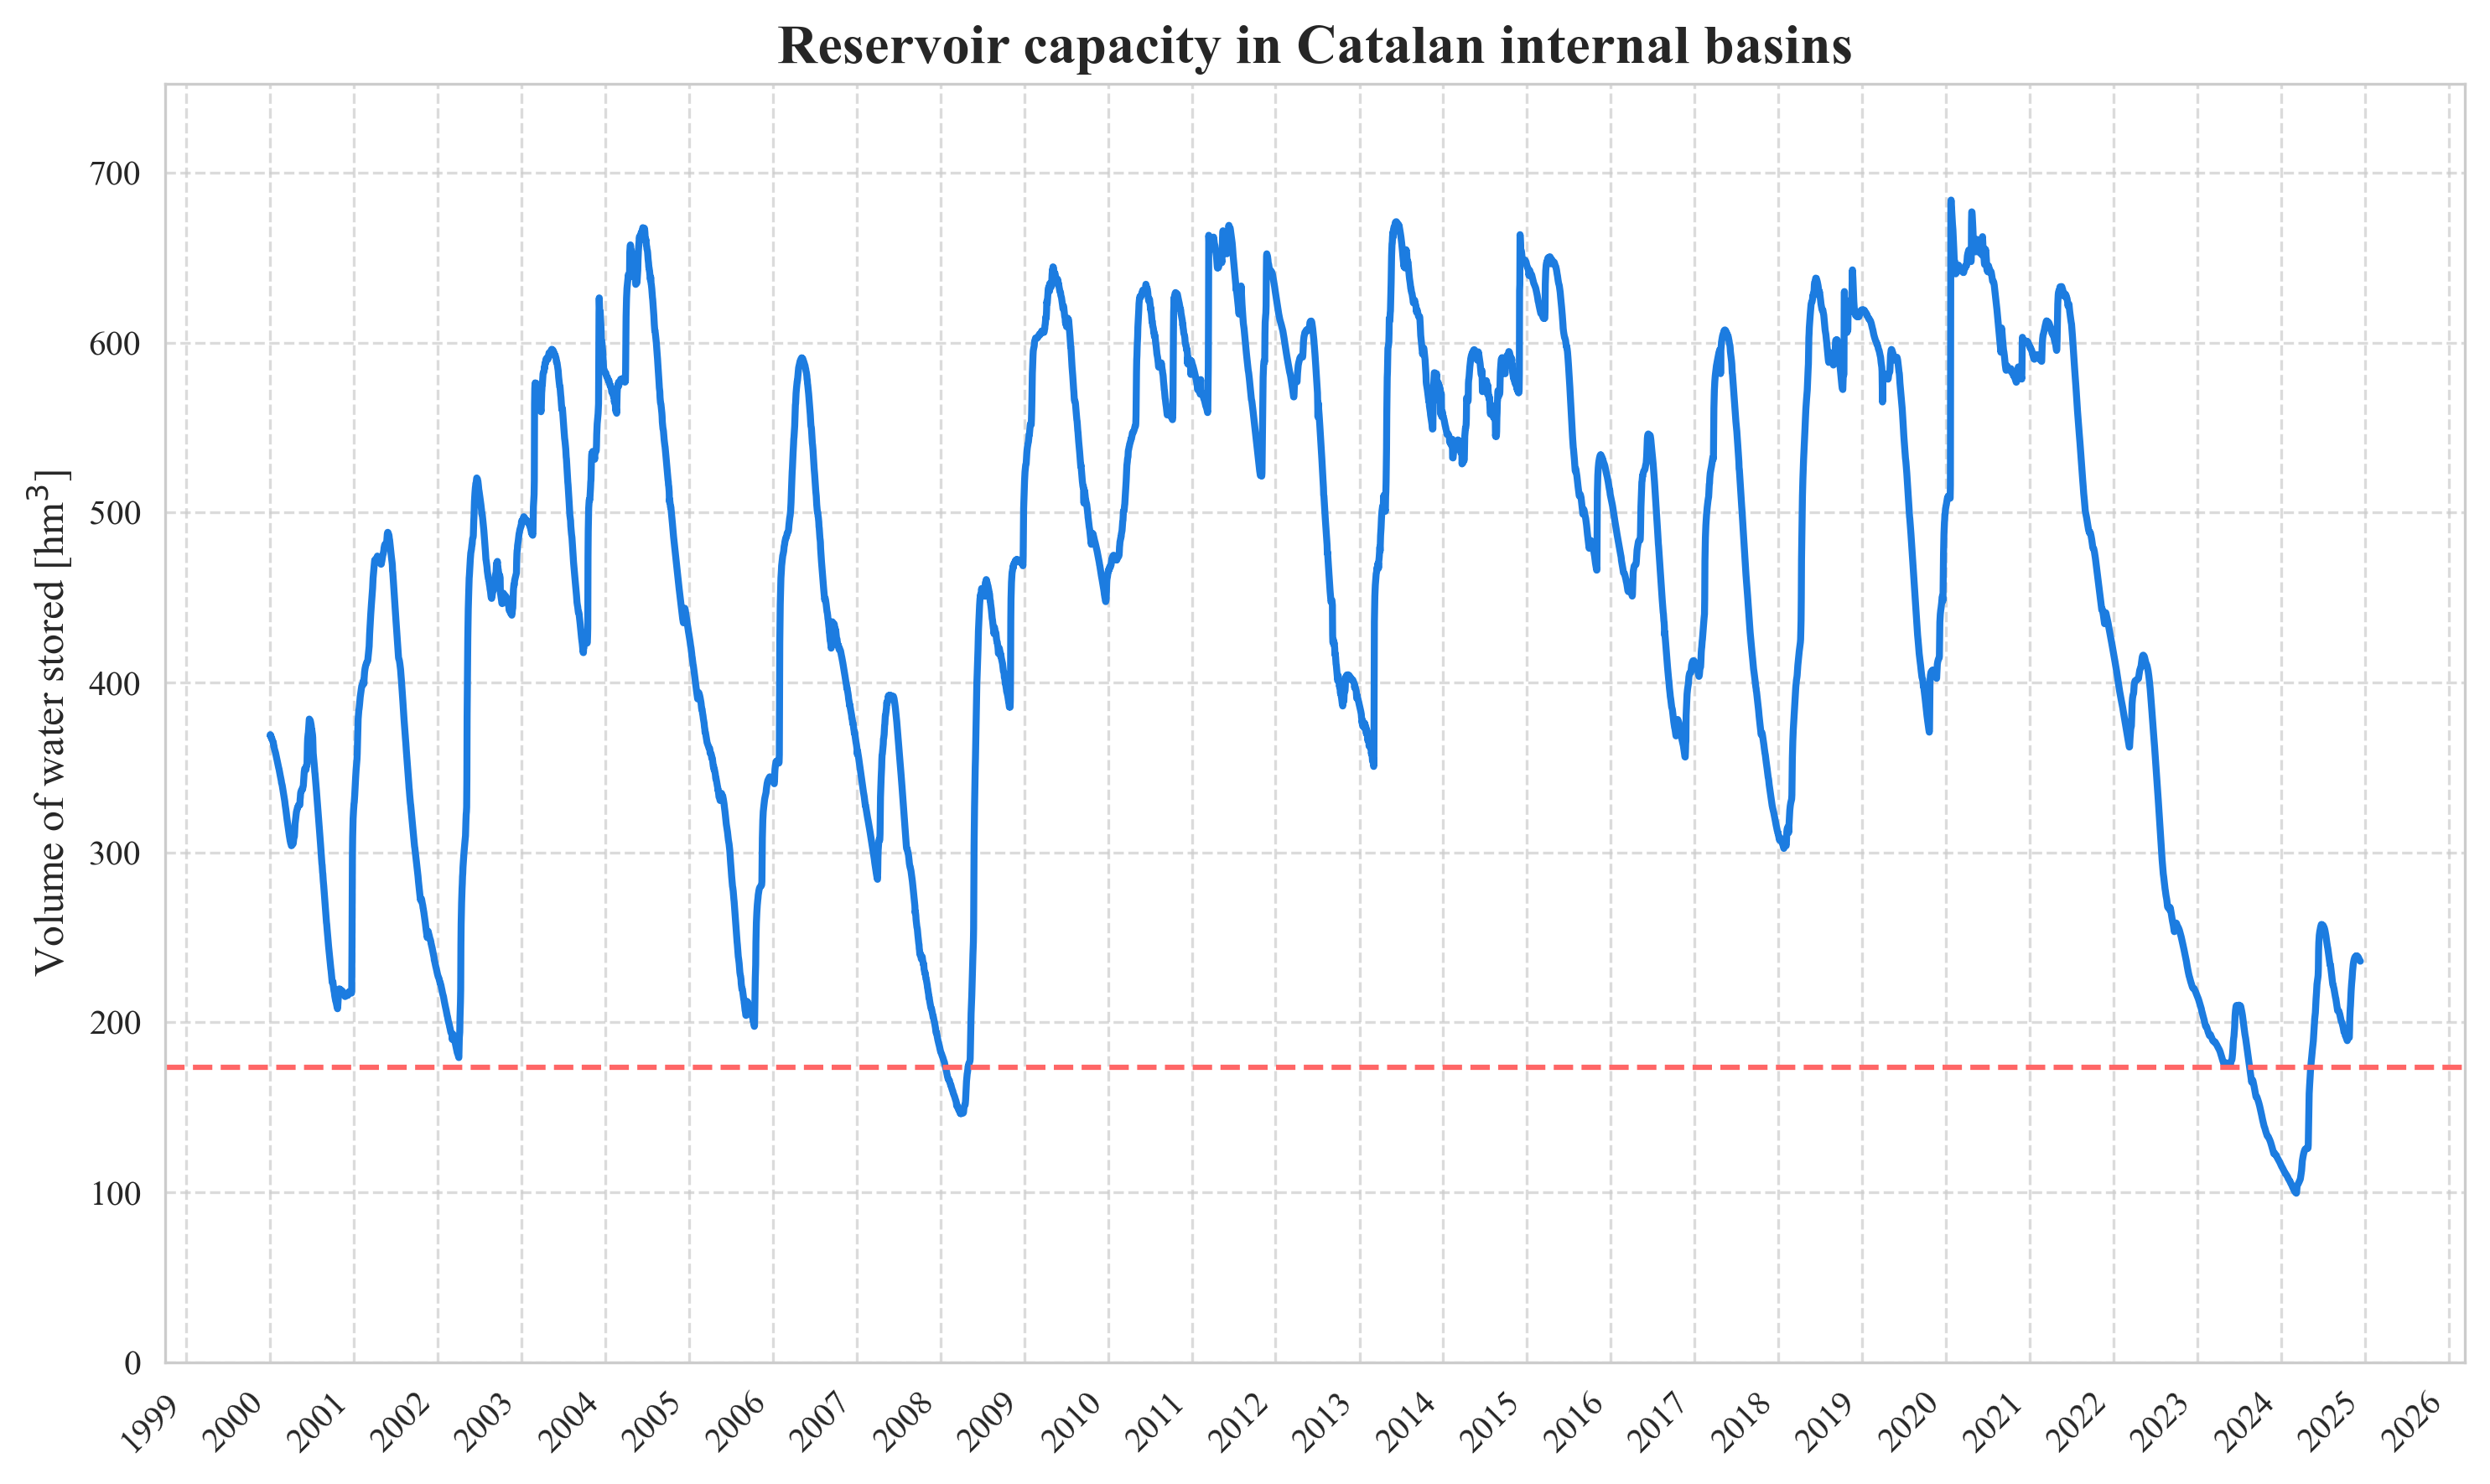

<Axes: >

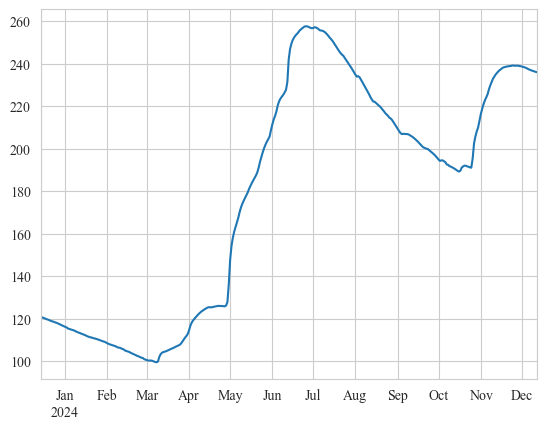

In [8]:
capacity_daily = df_agrupado['Actual']

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
# Graficar la serie temporal
ax.plot(capacity_daily.index, capacity_daily.values, color='#1C7CE0', linewidth=2)

# Añadir títulos y etiquetas
ax.set_title('Reservoir capacity in Catalan internal basins', fontsize=16, fontweight='bold')
ax.set_ylabel('Volume of water stored [hm$^3$]', fontsize=12)

# Configurar el eje x para mostrar las fechas correctamente
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Rotar las etiquetas del eje x para mejor legibilidad
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajustar los límites del eje y para evitar espacios en blanco excesivos
ax.set_ylim(0, capacity_daily.max() * 1.1)

# Añadir una cuadrícula suave
ax.grid(True, linestyle='--', alpha=0.7)

#ax.axhline(208, color='#FF6666', linestyle='--', linewidth=1.5)
ax.axhline(173.6, color='#FF6666', linestyle='--', linewidth=1.5)

# Ajustar los márgenes
plt.tight_layout()

# Guardar la figura como PNG
plt.savefig('reservoir_capacity.png', dpi=300, bbox_inches='tight')

# Mostrar la figura
plt.show()

# Gráfico para verificar que no haya datos faltantes en los registros recientes
capacity_daily[-365:].plot(xlabel='')

In [36]:
def load_and_process_desalination_data(domain, dataset_id, end_dataset_date, csv_file='dessalacio_data.csv'):
    # Comprobar si el archivo CSV existe y está actualizado
    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file, index_col='Dia', parse_dates=True)
        if df.index.max() >= pd.to_datetime(end_dataset_date):
            print("Datos cargados desde el archivo CSV.")
            return df['Volum (hm3)']

    # Si el archivo no existe o no está actualizado, cargar desde Socrata
    print("Cargando datos desde Socrata...")
    # Crear cliente Socrata
    client = Socrata(domain, None)
    # Obtener los datos (limita a 100000 registros, puedes ajustar este número)
    results = client.get(dataset_id, limit=100000)
    # Convertir results a un DataFrame de pandas
    df = pd.DataFrame.from_records(results)

    # Convertir 'dia' a datetime64
    df['dia'] = pd.to_datetime(df['dia'])
    # Convertir las columnas numéricas a float64
    df['volum_hm3'] = df['volum_hm3'].astype(float)
    # Modificar los nombres de las columnas
    df.columns = ['Dia', 'codi_estacio', 'nom_estacio', 'Volum (hm3)']
    
    dessalacio = df.groupby('Dia').sum()['Volum (hm3)']
    dessalacio.index = pd.to_datetime(dessalacio.index)
    dessalacio = dessalacio.resample('D').sum()
    dessalacio = dessalacio.replace(0, np.nan)
    dessalacio = dessalacio.interpolate()

    # Guardar los datos en un archivo CSV
    dessalacio.to_csv(csv_file)
    print(f"Datos guardados en {csv_file}")

    return dessalacio

# Configuración
domain = "analisi.transparenciacatalunya.cat"
dataset_id = "k8sn-8pqw"

# Cargar y procesar los datos
dessalacio = load_and_process_desalination_data(domain, dataset_id, end_dataset_date)

# Procesar datos mensuales
dessalacio_mensual = dessalacio.resample('ME').sum()
dessalacio_mensual = dessalacio_mensual[:end_dataset_date]

# Impresión de los últimos valores
print(dessalacio_mensual.tail())

# Calcular los términos correctores
dessalacio_base = dessalacio_mensual[:'2022-01-01'].mean()
dessalacio_full = dessalacio_mensual['2023-01-01':][:-1].mean()
dessalacio_extra = dessalacio_mensual - dessalacio_base

Cargando datos desde Socrata...
Datos guardados en dessalacio_data.csv
Dia
2024-07-31    6.562925
2024-08-31    6.669768
2024-09-30    5.691111
2024-10-31    5.556540
2024-11-30    3.496728
Freq: ME, Name: Volum (hm3), dtype: float64


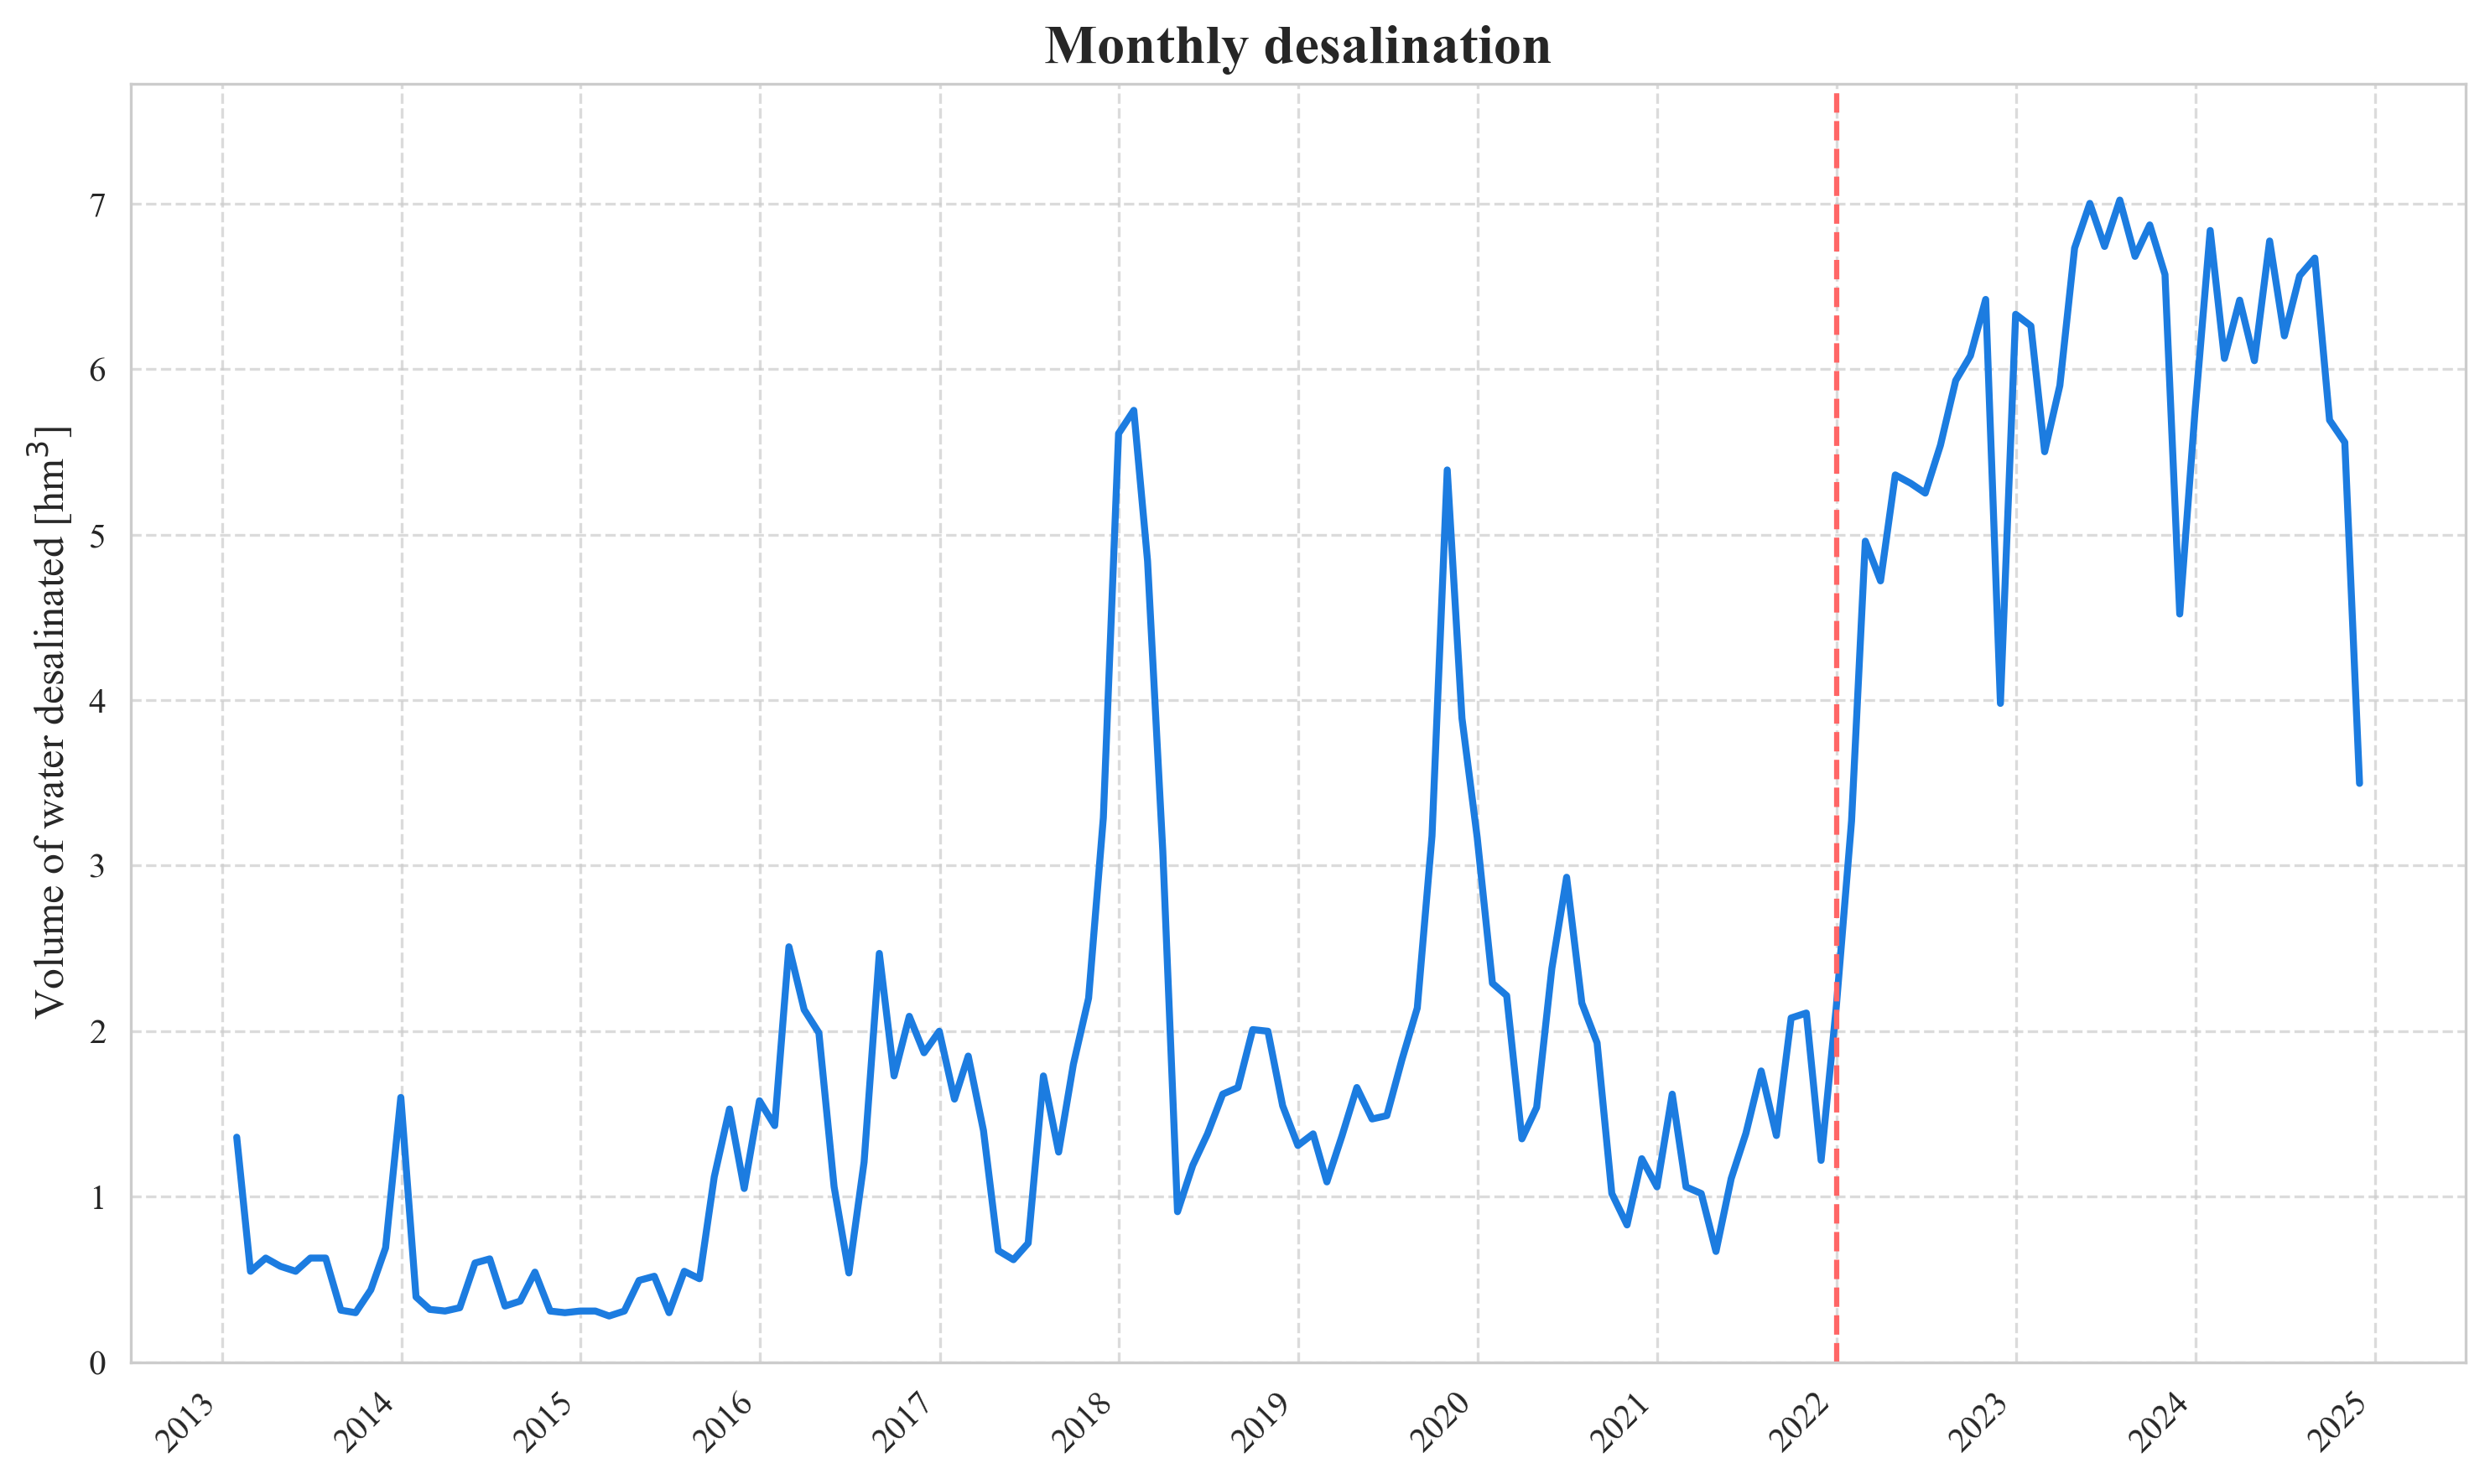

In [38]:
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
# Graficar la serie temporal
ax.plot(dessalacio_mensual.index, dessalacio_mensual.values, color='#1C7CE0', linewidth=2)

# Añadir títulos y etiquetas
ax.set_title('Monthly desalination', fontsize=16, fontweight='bold')
ax.set_ylabel('Volume of water desalinated [hm$^3$]', fontsize=12)

# Configurar el eje x para mostrar las fechas correctamente
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Rotar las etiquetas del eje x para mejor legibilidad
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajustar los límites del eje y para evitar espacios en blanco excesivos
ax.set_ylim(0, dessalacio_mensual.max() * 1.1)

# Añadir una cuadrícula suave
ax.grid(True, linestyle='--', alpha=0.7)

ax.axvline(pd.Timestamp('2022-01-01'), color='#FF6666', linestyle='--', linewidth=1.5)

# Ajustar los márgenes
plt.tight_layout()

# Mostrar la figura
plt.show()

In [40]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

# Crear las figuras de Plotly Express
fig_capacity = px.line(capacity_daily, x=capacity_daily.index, y=capacity_daily.values, title='Capacitat de les conques internes', labels={'y': 'Stored water [hm<sup>3</sup>]'})
fig_capacity.update_xaxes(title_text='')
fig_dessalacio = px.line(dessalacio_mensual, x=dessalacio_mensual.index, y=dessalacio_mensual.values, title='Dessalació', labels={'y': 'Desalinated water [hm<sup>3</sup>]'})
fig_dessalacio.update_xaxes(title_text='')

# Convertir las figuras a HTML
#fig_capacity_html = fig_capacity.to_html(full_html=False, include_plotlyjs='cdn')
#fig_dessalacio_html = fig_dessalacio.to_html(full_html=False, include_plotlyjs='cdn')


app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Tabs([
        dcc.Tab(label='Capacitat de les conques internes', children=[
            dcc.Graph(id='graph-capacity', figure=fig_capacity, style={'height': '80vh'})
        ], style={'fontSize': '20px'}, selected_style={'fontSize': '20px'}),
        dcc.Tab(label='Dessalació', children=[
            dcc.Graph(id='graph-dessalacio', figure=fig_dessalacio, style={'height': '80vh'})
        ], style={'fontSize': '20px'}, selected_style={'fontSize': '20px'}),
    ])
])

if __name__ == '__main__':
    app.run_server(debug=False, port=8054)  # Cambiado a 8054 para evitar conflictos de puerto

In [42]:
capacity_daily.resample('ME').mean()

Dia
2000-01-31    363.018065
2000-02-29    344.676897
2000-03-31    318.897419
2000-04-30    313.062000
2000-05-31    335.396452
                 ...    
2024-08-31    222.388710
2024-09-30    203.028000
2024-10-31    194.628065
2024-11-30    233.732000
2024-12-31    237.368333
Freq: ME, Name: Actual, Length: 300, dtype: float64

In [660]:
import plotly.express as px
import pandas as pd
import plotly.io as pio

# Crear las figuras de Plotly Express
fig_capacity = px.line(capacity_daily, x=capacity_daily.index, y=capacity_daily.values, title='Capacitat de les conques internes', labels={'y': 'Stored water [hm<sup>3</sup>]'})
fig_capacity.update_xaxes(title_text='')

fig_dessalacio = px.line(dessalacio_mensual, x=dessalacio_mensual.index, y=dessalacio_mensual.values, title='Dessalació', labels={'y': 'Desalinated water [hm<sup>3</sup>]'})
fig_dessalacio.update_xaxes(title_text='')

# Convertir las figuras a HTML
html_capacity = pio.to_html(fig_capacity, full_html=False)
html_dessalacio = pio.to_html(fig_dessalacio, full_html=False)

# Crear el HTML completo
html_string = f"""
<html>
<head>
    <title>Dashboard</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
</head>
<body>
    <h2>Capacitat de les conques internes</h2>
    {html_capacity}
    <h2>Dessalació</h2>
    {html_dessalacio}
</body>
</html>
"""

# Guardar en un archivo
with open('dashboard.html', 'w', encoding='utf-8') as f:
    f.write(html_string)

print("HTML file 'dashboard.html' has been created.")

HTML file 'dashboard.html' has been created.


In [676]:
import plotly.express as px
import pandas as pd
import plotly.io as pio

# Crear las figuras de Plotly Express con un tamaño mayor
fig_capacity = px.line(capacity_daily, x=capacity_daily.index, y=capacity_daily.values, title='Reservoir capacity of Catalan internal basins', labels={'y': 'Stored water [hm<sup>3</sup>]'})
fig_capacity.update_xaxes(title_text='')
fig_capacity.update_layout(height=600, autosize=True)

fig_dessalacio = px.line(dessalacio_mensual, x=dessalacio_mensual.index, y=dessalacio_mensual.values, title='Monthly desalination', labels={'y': 'Desalinated water [hm<sup>3</sup>]'})
fig_dessalacio.update_xaxes(title_text='')
fig_dessalacio.update_layout(height=600, autosize=True)

# Convertir las figuras a HTML
html_capacity = pio.to_html(fig_capacity, full_html=False, config={'responsive': True})
html_desalination = pio.to_html(fig_dessalacio, full_html=False, config={'responsive': True})

# Crear el HTML completo con pestañas y diseño responsivo
html_string = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Dashboard</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}
        .container {{
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
        }}
        .tab {{
            overflow: hidden;
            background-color: #f1f1f1;
            display: flex;
            flex-wrap: wrap;
        }}
        .tab button {{
            background-color: inherit;
            border: none;
            outline: none;
            cursor: pointer;
            padding: 14px 16px;
            transition: 0.3s;
            font-size: 16px;
            flex-grow: 1;
        }}
        .tab button:hover {{
            background-color: #ddd;
        }}
        .tab button.active {{
            background-color: #ccc;
        }}
        .tabcontent {{
            display: none;
            padding: 6px 12px;
        }}
        .plotly-graph-div {{
            width: 100%;
            height: 70vh;
            min-height: 400px;
        }}
        @media screen and (max-width: 600px) {{
            .tab button {{
                width: 100%;
            }}
            .plotly-graph-div {{
                height: 50vh;
            }}
        }}
    </style>
</head>
<body>
    <div class="container">
        <div class="tab">
            <button class="tablinks" onclick="openTab(event, 'Capacity')" id="defaultOpen">Reservoir capacity</button>
            <button class="tablinks" onclick="openTab(event, 'Desalination')">Desalination</button>
        </div>

        <div id="Capacity" class="tabcontent">
            {html_capacity}
        </div>

        <div id="Desalination" class="tabcontent">
            {html_desalination}
        </div>
    </div>

    <script>
    function openTab(evt, tabName) {{
        var i, tabcontent, tablinks;
        tabcontent = document.getElementsByClassName("tabcontent");
        for (i = 0; i < tabcontent.length; i++) {{
            tabcontent[i].style.display = "none";
        }}
        tablinks = document.getElementsByClassName("tablinks");
        for (i = 0; i < tablinks.length; i++) {{
            tablinks[i].className = tablinks[i].className.replace(" active", "");
        }}
        document.getElementById(tabName).style.display = "block";
        evt.currentTarget.className += " active";
        window.dispatchEvent(new Event('resize'));
    }}

    document.getElementById("defaultOpen").click();

    window.addEventListener('resize', function() {{
        var graphs = document.getElementsByClassName('plotly-graph-div');
        for(var i = 0; i < graphs.length; i++) {{
            Plotly.Plots.resize(graphs[i]);
        }}
    }});
    </script>
</body>
</html>
"""

# Guardar en un archivo
with open('dashboard.html', 'w', encoding='utf-8') as f:
    f.write(html_string)

print("HTML file 'dashboard.html' has been created with improved sizing for desktop and mobile.")



HTML file 'dashboard.html' has been created with improved sizing for desktop and mobile.
